# 第7章　機械学習

scikit-learn をつかう

## 60. データの入手・整形

GLUEのウェブサイトからSST-2データセットを取得せよ。学習データ（train.tsv）と検証データ（dev.tsv）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [1]:
# zip ファイルの解凍
!unzip /content/SST-2.zip

Archive:  /content/SST-2.zip
   creating: SST-2/
  inflating: SST-2/dev.tsv           
   creating: SST-2/original/
  inflating: SST-2/original/README.txt  
  inflating: SST-2/original/SOStr.txt  
  inflating: SST-2/original/STree.txt  
  inflating: SST-2/original/datasetSentences.txt  
  inflating: SST-2/original/datasetSplit.txt  
  inflating: SST-2/original/dictionary.txt  
  inflating: SST-2/original/original_rt_snippets.txt  
  inflating: SST-2/original/sentiment_labels.txt  
  inflating: SST-2/test.tsv          
  inflating: SST-2/train.tsv         


In [2]:
# データの読み込み
import pandas as pd

train = pd.read_csv('/content/SST-2/train.tsv', sep='\t')
dev = pd.read_csv('/content/SST-2/dev.tsv', sep='\t')

train.head(5)

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [3]:
dev.head(5)

,sentence,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0


In [4]:
# ネガポジの事例数(train)
train['label'].value_counts()

,count
label,
1,37569
0,29780


In [5]:
# ネガポジの事例数(dev)
dev['label'].value_counts()

,count
label,
1,444
0,428


## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（train.tsv）および検証データ（dev.tsv）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、”too loud , too goofy”というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

In [6]:
# 特徴ベクトルの作成
# 'text':'sentence', 'label':'label', feature:{'word': 'count'}

from collections import Counter

# BoWに変換
def text_to_bow(text):
    tokens = text.strip().split()

    return dict(Counter(tokens))

# 特徴ベクトル付きの辞書を作成
def make_feature_dict(data):
  processed_data = []
  for i, item in data.iterrows():
     text = item["sentence"]
     label = item["label"]
     feature = text_to_bow(text)
     processed_data.append({
         "text": text,
         "label": label,
         "feature": feature
     })
     #print(processed_data)
  return processed_data

# train, dev で特徴ベクトルを作成
processed_train = make_feature_dict(train)
processed_dev = make_feature_dict(dev)

In [7]:
# 学習データの最初の事例を目視確認
from pprint import pprint
pprint(processed_train[0])

{'feature': {'from': 1,
             'hide': 1,
             'new': 1,
             'parental': 1,
             'secretions': 1,
             'the': 1,
             'units': 1},
 'label': 0,
 'text': 'hide new secretions from the parental units '}


In [8]:
pprint(processed_dev[0])

{'feature': {"'s": 1,
             '.': 1,
             'a': 1,
             'affecting': 1,
             'and': 1,
             'charming': 1,
             'it': 1,
             'journey': 1,
             'often': 1},
 'label': 1,
 'text': "it 's a charming and often affecting journey . "}


In [9]:
# 数の確認
print(len(processed_train))
print(len(processed_dev))

67349
872


## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [10]:
# ロジスティック回帰モデル
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')

In [12]:
# 特徴ベクトルを数値へ変換
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
X_train_dicts = [item["feature"] for item in processed_train]
X_train = vectorizer.fit_transform(X_train_dicts)
y_train = [item["label"] for item in processed_train]

In [13]:
print(X_train[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 14816)>
  Coords	Values
  (0, 5294)	1.0
  (0, 6138)	1.0
  (0, 8769)	1.0
  (0, 9369)	1.0
  (0, 11389)	1.0
  (0, 13131)	1.0
  (0, 13896)	1.0


In [14]:
# 学習
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [15]:
# 結果の確認
print('coefficient = ', model.coef_[0]) # 説明変数の係数を出力
print('intercept = ', model.intercept_) # 切片を出力

coefficient =  [ 0.89578179  0.35787981 -0.64256694 ...  0.0898757  -1.8353861
  0.01924432]
intercept =  [0.34494306]


## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [18]:
# 検証データを辞書から数値に変更

X_dev_dicts = [item["feature"] for item in processed_dev]
y_dev = [item["label"] for item in processed_dev]

# 辞書をベクトルに変換 train と特徴ベクトルのサイズをそろえるためにfitを使わない
X_dev = vectorizer.transform(X_dev_dicts)

In [19]:
print(X_dev[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9 stored elements and shape (1, 14816)>
  Coords	Values
  (0, 22)	1.0
  (0, 34)	1.0
  (0, 210)	1.0
  (0, 443)	1.0
  (0, 686)	1.0
  (0, 2181)	1.0
  (0, 6986)	1.0
  (0, 7133)	1.0
  (0, 9011)	1.0


In [22]:
# 検証データの先頭事例のラベルを推測
y_pred = model.predict(X_dev)
print("y_dev:", y_dev[0])
print("y_pred:", y_pred[0])

y_dev: 1
y_pred: 1


## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [23]:
# 条件付確率の表示
p = model.predict_proba(X_dev[0])
print(p)

[[0.00419195 0.99580805]]


## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして”the worst movie I ‘ve ever seen”を与え、ロジスティック回帰モデルの予測結果を確認せよ。

In [24]:
text = "the worst movie I've ever seen"
print(model.predict(vectorizer.transform(text_to_bow(text))))

[0]


## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

In [25]:
from sklearn.metrics import confusion_matrix # 混同行列
print('confusion matrix = \n', confusion_matrix(y_true=y_dev, y_pred=y_pred))

confusion matrix = 
 [[334  94]
 [ 71 373]]


## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 検証データ
print('accuracy = ', accuracy_score(y_true=y_dev, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_dev, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_dev, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_dev, y_pred=y_pred))

accuracy =  0.8107798165137615
precision =  0.7987152034261242
recall =  0.8400900900900901
f1 score =  0.818880351262349


In [27]:
y_train_pred = model.predict(X_train)

In [28]:
# 学習データ
print('accuracy = ', accuracy_score(y_true=y_train, y_pred=y_train_pred))
print('precision = ', precision_score(y_true=y_train, y_pred=y_train_pred))
print('recall = ', recall_score(y_true=y_train, y_pred=y_train_pred))
print('f1 score = ', f1_score(y_true=y_train, y_pred=y_train_pred))

accuracy =  0.9428350829262498
precision =  0.9434726569692506
recall =  0.9547233091112354
f1 score =  0.9490646416002964


## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [33]:
import numpy as np

# model: 学習済みのロジスティック回帰モデル
# vectorizer: 使ったCountVectorizerまたはDictVectorizer

# 重みを取得（2次元なので注意）
weights = model.coef_[0]

# 特徴量名
feature_names = vectorizer.get_feature_names_out()

# 重みと特徴量をセットに
feature_weight_pairs = list(zip(feature_names, weights))

# 重みでソート
sorted_features = sorted(feature_weight_pairs, # 特徴量（特徴量の名前, 重み）のタプルリスト
                         key=lambda x: x[1], # 重みを基準にしてソートする
                         reverse=True) # 降順（重みが大きい順）

# 5. トップ20（重みが大きい方）
top_20 = sorted_features[:20]

# 6. ワースト20（重みが小さい方）
bottom_20 = sorted_features[-20:]

# 結果を表示
print("Top 20:")
for feature, weight in top_20:
    print(f"{feature}: {weight:.4f}")

print("\nBottom 20:")
for feature, weight in bottom_20:
    print(f"{feature}: {weight:.4f}")


Top 20:
refreshing: 3.4798
remarkable: 3.4740
powerful: 3.2547
hilarious: 3.1916
beautiful: 3.0083
wonderful: 2.9951
prose: 2.9325
terrific: 2.9240
treat: 2.8799
appealing: 2.8640
enjoyable: 2.8297
charmer: 2.7813
vividly: 2.7234
likable: 2.7057
solid: 2.6377
charming: 2.6361
impressive: 2.6157
half-bad: 2.5875
fascinating: 2.5872
intriguing: 2.5580

Bottom 20:
unfortunately: -2.9689
pointless: -3.0063
poor: -3.0134
lousy: -3.0141
hardly: -3.0192
none: -3.0241
squanders: -3.0506
lack: -3.0788
waste: -3.1931
loses: -3.2167
depressing: -3.2174
flat: -3.2291
bore: -3.3023
stupid: -3.3733
failure: -3.6440
mess: -3.6980
devoid: -3.7064
worst: -4.0191
lacks: -4.0883
lacking: -4.3574


## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

In [34]:
# 正則化係数を変化させたときの正解率の変化

# 正規化係数の設定
C_list = [10 ** i for i in range(-5, 5)]

# 正解率を格納するリスト
dev_accuracy = []

# モデルの学習
for C in C_list:
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_dev)
    dev_accuracy.append(accuracy_score(y_true=y_dev, y_pred=y_pred))

In [35]:
# 中身確認
print(dev_accuracy)

[0.5091743119266054, 0.5275229357798165, 0.6846330275229358, 0.7557339449541285, 0.8004587155963303, 0.8107798165137615, 0.8245412844036697, 0.7947247706422018, 0.7775229357798165, 0.7706422018348624]


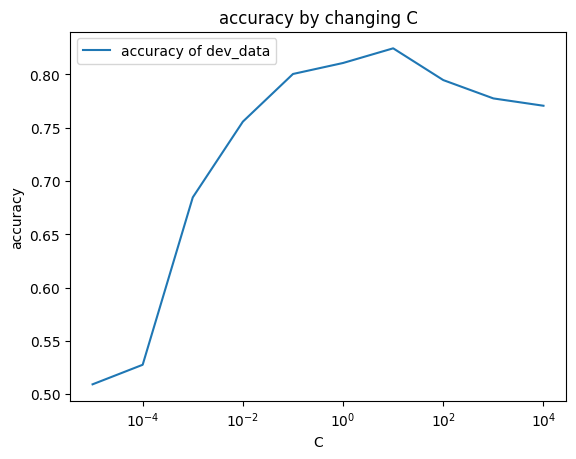

In [36]:
# 結果の表示
import matplotlib.pyplot as plt

# semilogx()はxのスケールを10のx乗のスケールに変更できる
plt.semilogx(C_list, dev_accuracy, label="accuracy of dev_data")
plt.title("accuracy by changing C")
plt.xlabel("C")
plt.ylabel("accuracy")
plt.legend()
plt.show()

参考

https://www.tech-teacher.jp/blog/logistic-regression-python/

https://qiita.com/setowatson/items/8f0536f70fe22fb1664a